In [305]:
import numpy as np
import scipy
import pylab as mplot
from scipy import interpolate as intrp
from scipy import integrate as intg

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
%pylab inline
import matplotlib.colors as mcolors
import matplotlib as pl
import scipy.optimize as op


Populating the interactive namespace from numpy and matplotlib


In [306]:
velocity = np.loadtxt("phase_space_zmin0.1_zmax0.2_withlam.dat")

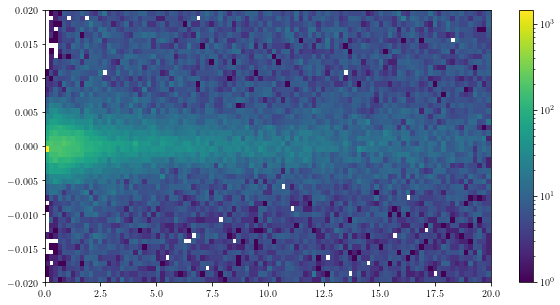

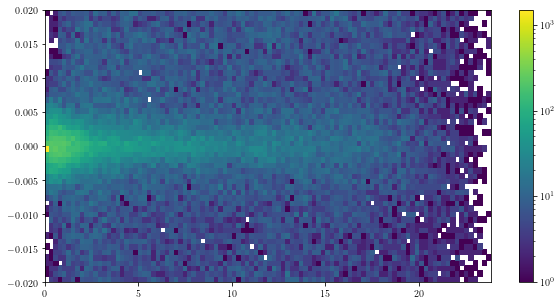

In [307]:
R = velocity[:,0]
dz = velocity[:,1]
Lambda = velocity[:,5]
Mag = velocity[:,3]
# R = R[Mag<-20]
# dz = dz[Mag<-20]
# Lambda =Lambda[Mag<-20]

mean_lambda = np.mean(Lambda)
R_scale = R/(Lambda/mean_lambda)**(1./3)
mplot.figure(figsize=(10,5))
mplot.hist2d(R, dz, bins=(100,50), norm=pl.colors.LogNorm())
mplot.colorbar()
mplot.figure(figsize=(10,5))
mplot.hist2d(R_scale, dz, bins=(100,50), norm=pl.colors.LogNorm())
mplot.colorbar()

(array([5800., 6655., 4245., 4258., 3374., 3185., 2669., 1919., 2115.,
        2071., 1373., 1746., 1224.,  993., 1140.,  803.,  850.,  703.,
         911.,  672.,  554., 1015.,  310.,  790.,  409.,  409.,  224.,
         217.,  147.,  456.,  135.,  205.,  170.,   99.,   59.,   37.,
          94.,  196.,  115.,  283.,   91.,   92.,    0.,    0.,   96.,
          96.,   23.,    0.,    0.,  225.]),
 array([20.00348473, 21.60159588, 23.19970703, 24.79781818, 26.39592934,
        27.99404049, 29.59215164, 31.19026279, 32.78837395, 34.3864851 ,
        35.98459625, 37.58270741, 39.18081856, 40.77892971, 42.37704086,
        43.97515202, 45.57326317, 47.17137432, 48.76948547, 50.36759663,
        51.96570778, 53.56381893, 55.16193008, 56.76004124, 58.35815239,
        59.95626354, 61.55437469, 63.15248585, 64.750597  , 66.34870815,
        67.94681931, 69.54493046, 71.14304161, 72.74115276, 74.33926392,
        75.93737507, 77.53548622, 79.13359737, 80.73170853, 82.32981968,
        83.92793

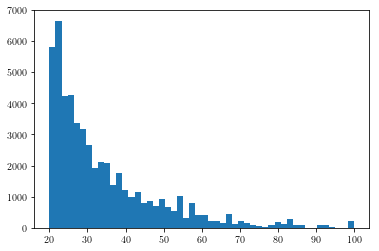

In [308]:
mplot.hist(Lambda, bins=50)

In [309]:
bin_edge = np.logspace(np.log10(20), np.log10(100), num=11)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]
print(bin_min)

[20.         23.49237886 27.59459323 32.41313193 38.07307877 44.72135955
 52.53055609 61.70338627 72.47796637 85.13399225]


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[1.0000000e-04 1.5000000e+00 6.5894277e-01]
[0.0023843  0.51932676 0.9       ]
[0.00243819 0.4003448  0.9       ]
[0.00243862 0.36323636 0.88902067]
[0.00224315 0.38735643 0.84778425]
[0.00198201 0.38845556 0.79680022]
[0.0020953  0.43242776 0.7596229 ]
[0.00202036 0.52062814 0.71264438]
[0.00179837 0.29239338 0.67193531]
[0.00193351 0.20051507 0.63930808]
[0.00211963 0.24859752 0.57364616]
[0.00193706 0.1        0.53385915]
[0.00228504 0.46740881 0.54768026]
[0.00198402 0.42844955 0.47380488]
[0.00192913 0.39114652 0.47831636]
[0.00204362 0.1        0.44650042]
[0.00185709 0.1        0.46558292]
[0.00245612 0.39852663 0.41937161]
[0.00248312 0.1        0.54074328]
[0.00220397 0.17405254 0.43179684]


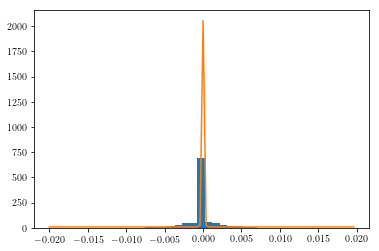

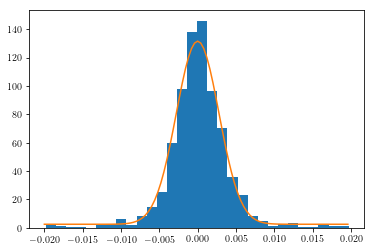

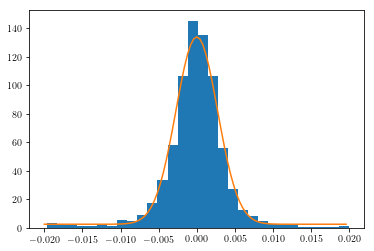

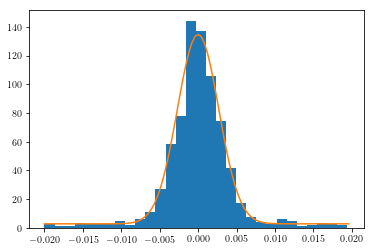

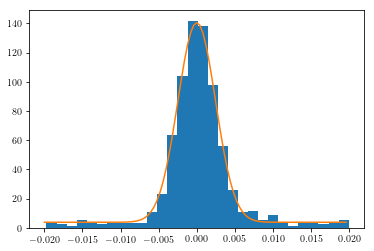

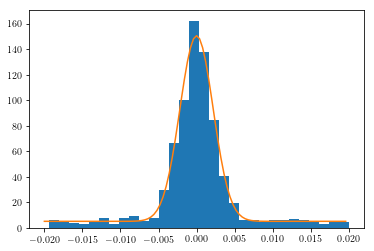

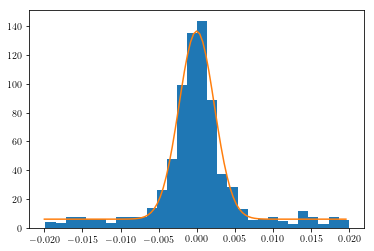

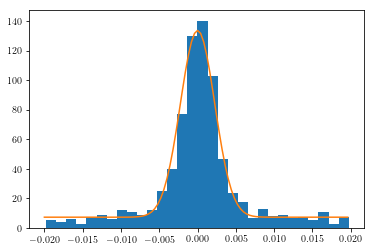

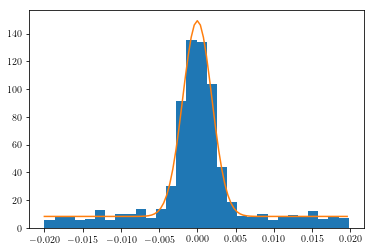

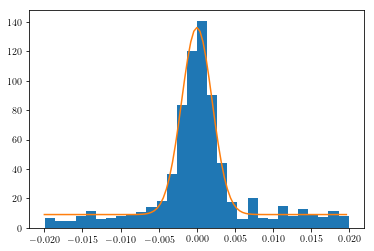

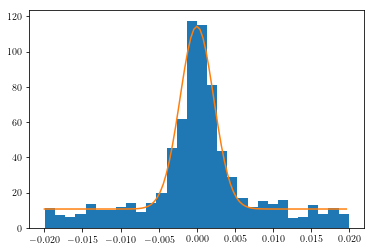

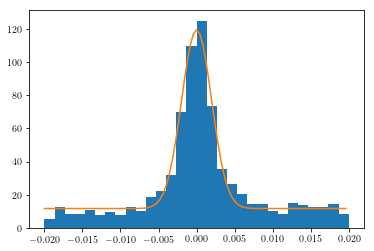

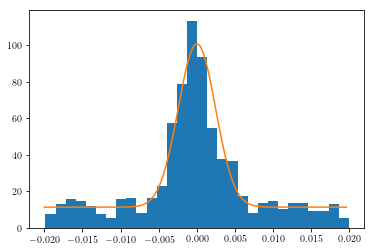

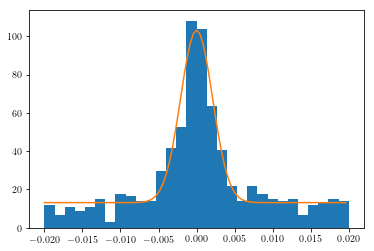

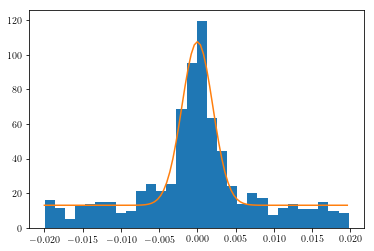

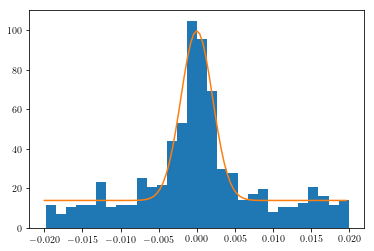

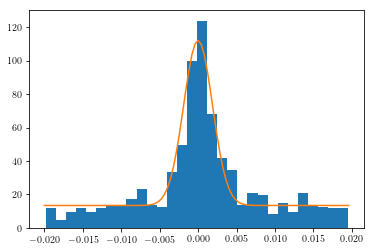

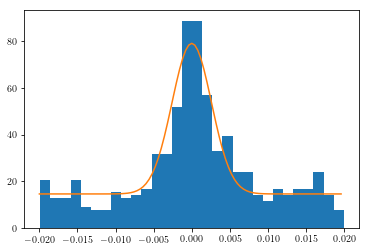

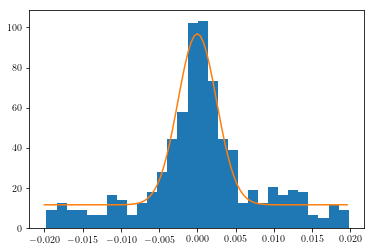

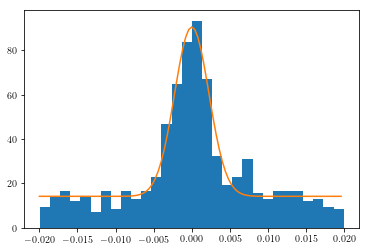

In [311]:
Results = []
for i in range(20):
    r_mask = (R_scale>=i*0.2)*(R_scale<(i+1)*0.2)
    args = (dz[r_mask], Lambda[r_mask])
    result = op.minimize(nll, p0, args=args, method = method, options={'disp':True}, bounds = bounds)

    mplot.figure()
    mplot.hist(dz[r_mask], bins=30, normed=1)
    sigma0, alpha, p = result.x
    print(result.x)
    sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
    like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04 #*(B*ddz -0.02*B + 1./0.04)
    mplot.plot(ddz, like)
    Results.append(result.x)
Results = np.array(Results)

(0.0, 0.8)

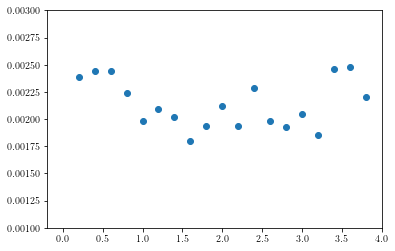

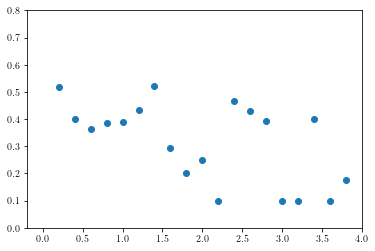

In [317]:
Results = np.array(Results)
mplot.figure()
mplot.scatter(np.arange(len(Results[:,1]))*0.2, Results[:,0])
mplot.ylim(0.001,0.003)
mplot.figure()
mplot.scatter(np.arange(len(Results[:,1]))*0.2, Results[:,1])
mplot.ylim(0.0,0.8)

[0.00199711 0.48718793 0.41983683]


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


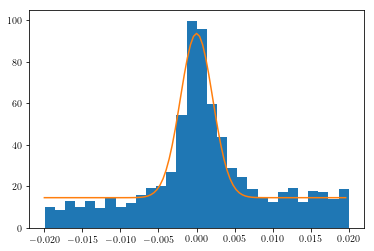

In [304]:
# def model(dz, lamb, A, B, C, sigma0, lamb0, alpha):
#     """model for each R bin"""

#     sigma0 = (lamb/lamb0)**alpha
#     return A*np.exp(-0.5*(C*dz)**2/sigma**2) + B

#     mod = model(dz, lamb, A, B, C, sigma0, lamb0, alpha)
#     diff = data_vec - model
#     detinvcov = np.linalg.det(invcov)
#     detcov = 1./detinvcov
#     lnlike = -0.5*(len(data_vec)*np.log(2.*np.pi) + np.log(detcov)) -0.5*np.dot(diff, np.dot(invcov, diff))


def lnlike(params, dz, lamb):
    """In one R bin, input data is delta z"""

    sigma0, alpha, p = params
    sigma  = sigma0* (lamb/30.0)**alpha
    like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*dz**2/sigma**2) + (1.-p)/0.04 #*(B*dz -0.02*B + 1./0.04 + 0.02*0.04)
    lnlike_out = np.sum(np.log(like))

#     print(lnlike_out)
    return lnlike_out
 

nll = lambda *args: -lnlike(*args)
method = 'L-BFGS-B'
args = []
p0 = [0.001, 1.0, 0.8]
bounds = ((0.0001,0.1), (0.1,1.5), (0.01,0.9))


r_mask = (R_scale>=4)*(R_scale<5)
args = (dz[r_mask], Lambda[r_mask])
result = op.minimize(nll, p0, args=args, method = method, options={'disp':True}, bounds = bounds)


mplot.hist(dz[r_mask], bins=30, normed=1)
sigma0, alpha, p = result.x
sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04
#*(B*ddz -0.02*B + 1./0.04 + 0.02*0.04) #/0.04
mplot.plot(ddz, like)

#int ax  + b = 1
#0.04* a/2 + b = 1
#b = -0.02a

#B 0.04*0.02 - 0.02*0.04 - 0.02 B 0.04

# sigma = 0.003
# like2 = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)*300
# mplot.plot(ddz, like2*5)

#(10,300), (10,50), 


# res = op.least_squares(nll, p0, bounds=(0, 100), args=args, verbose=1)
print(result.x)
# print(lnlike(p0, dz[r_mask], Lambda[r_mask]))
# params = [A, B, C, sigma0, lamb0, alpha]


In [ ]:
like2 = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)*100

0.002


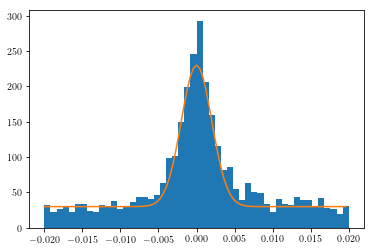

In [96]:
r_mask = (R_scale>=3)*(R_scale<4)
mplot.hist(dz[r_mask], range=(-0.02,0.02), bins=50)
ddz = np.arange(100)*0.0004-0.02
sigma = 0.002*(30./30)**0.5
print(sigma)
mplot.plot(ddz, 200*np.exp(-0.5*(ddz)**2/sigma**2) + 30)

In [126]:
print(Lambda)

[82.12174225 82.12174225 82.12174225 ... 25.15966606 25.15966606
 25.15966606]


In [ ]:
#TODO:
# need redshift
# 